[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/02_tutorial_NetworkTrainingVisualization.ipynb)



### Visualizing the training of Neural Networks with Pure Python / Tutorials

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 2, Tutorials

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:



*   visualize the training of neural networks



The networks have 2 input and 1 output neurons, but arbitrarily many hidden layers, and also you can choose the activation functions

This is essentially an extension of the lecture-1 notebook, but now including backpropagation.


### Imports: only numpy and matplotlib

In [ ]:
# Packages
import numpy as np
import matplotlib.pyplot as plt # for plotting
import matplotlib

### Implement backpropagation for a general (fully connected) network

In [ ]:
# sigmoid activation function
def sigmoid(z):
    val = np.where( z<0., np.exp(z)/(1.+np.exp(z)), 1./(1.+np.exp(-z)) )
    return val,val*(1-val) # return both f and f'

# relu activation function
def relu(z):
    return (z>0)*z,z>0 # return both f and f'

def forward_step(y,w,b,a): # calculate values in next layer, from input y
    z=np.dot(y,w)+b # w=weights, b=bias vector for next layer
    return a(z) # apply nonlinearity "a" and return result

def apply_net(x,Weights,Biases,Activations): # one forward pass through the network
    y_layer=[] # to save the neuron values
    df_layer=[] # to save the f'(z) values
    y=x # start with input values
    y_layer.append(y)
    for w,b,a in zip(Weights,Biases,Activations): # loop through all layers
        y,df=forward_step(y,w,b,a) # one step
        df_layer.append(df) # store f'(z) [needed later in backprop]
        y_layer.append(y) # store f(z) [also needed in backprop]
    return y,y_layer,df_layer

def apply_net_simple(x,Weights,Biases,Activations): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)
    y=x # start with input values
    for w,b,a in zip(Weights,Biases,Activations): # loop through all layers
        y,_=forward_step(y,w,b,a) # one step
    return y

def backward_step(delta,w,df):
    # delta: (batchsize,layersize(N)), w: (layersize(N-1),layersize(N))
    # df = df/dz at layer N-1, shape: (batchsize,layersize(N-1))
    return  np.dot(delta,np.transpose(w))*df

def backprop(y_target,y_layer,df_layer,Weights,Biases):
    # one backward pass through the network

    batchsize=np.shape(y_target)[0]
    num_layers=len(Weights) # number of layers excluding input
    dw_layer=[None]*num_layers # dCost/dw
    db_layer=[None]*num_layers # dCost/db

    delta=(y_layer[-1]-y_target)*df_layer[-1] # from derivative of mean squared loss
    dw_layer[-1]=np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    #assert not (np.nan in dw_layer[-1] or np.nan in db_layer[-1])

    for j in range(num_layers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=np.dot(np.transpose(y_layer[-3-j]),delta)/batchsize
        db_layer[-2-j]=delta.sum(0)/batchsize
        #assert not (np.nan in dw_layer[-2-j] or np.nan in db_layer[-2-j])

    return dw_layer,db_layer # gradients for weights & biases

def gradient_step(eta,dw_layer,db_layer,Weights,Biases):
    # update weights & biases (after backprop!)
    num_layers=len(Weights)
    for j in range(num_layers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
    return Weights, Biases

def train_batch(x,y_target,eta,Weights,Biases,Activations): # one full training batch
    # x is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    batchsize=np.shape(y_target)[0]
    y_out_result,y_layer,df_layer=apply_net(x,Weights,Biases,Activations)
    dw_layer,db_layer=backprop(y_target,y_layer,df_layer,Weights,Biases)
    Weights,Biases=gradient_step(eta,dw_layer,db_layer,Weights,Biases)
    cost=((y_target-y_out_result)**2).sum()/batchsize
    return y_out_result,cost,Weights,Biases

In [25]:
# @title Visualization (Refactored)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# For plotting
matplotlib.rcParams['figure.dpi'] = 300 # highres display
from matplotlib import gridspec # for subplots within subplots
# DEPRECATED IMPORT REMOVED: from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from IPython.display import clear_output # for updating display

# visualization routines:

def squeeze(z): # map real values into the range (0, 1)
    if z < 0:
        return np.exp(z)/(1.+np.exp(z))
    else:
        return 1./(1.+np.exp(-z))

# some internal routines for plotting the network:
def plot_connection_line(ax, X, Y, W, vmax=1.0, linewidth=3):
    t = np.linspace(0, 1, 20)
    if W > 0:
        col = [0, 0.4, 0.8]
    else:
        col = [1, 0.3, 0]
    alpha = squeeze(W)
    ax.plot(X[0] + (3 * t**2 - 2 * t**3) * (X[1] - X[0]), Y[0] + t * (Y[1] - Y[0]),
            alpha=alpha, color=col,
            linewidth=linewidth)

def plot_neuron_alpha(ax, X, Y, B, size=100.0, vmax=1.0):
    if B > 0:
        col = [0, 0.4, 0.8]
    else:
        col = [1, 0.3, 0]
    alpha = squeeze(B)
    ax.scatter([X], [Y], marker='o', c=col, alpha=alpha, s=size, zorder=10)

def plot_neuron(ax, X, Y, B, size=100.0, vmax=1.0):
    if B > 0:
        col = [0, 0.4, 0.8]
    else:
        col = [1, 0.3, 0]
    ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)

def visualize_network(weights, biases, activations,
                      M=100, y0range=[-1, 1], y1range=[-1, 1],
                      size=400.0, linewidth=5.0,
                      weights_are_swapped=False,
                      layers_already_initialized=False,
                      plot_cost_function=None,
                      current_cost=None, cost_max=None, plot_target=None
                      ):
    """
    Visualize a neural network with 2 input
    neurons and 1 output neuron (plot output vs input in a 2D plot)
    (Function description as in original code)
    """
    if not weights_are_swapped:
        swapped_weights = []
        for j in range(len(weights)):
            swapped_weights.append(np.transpose(weights[j]))
    else:
        swapped_weights = weights

    y0, y1 = np.meshgrid(np.linspace(y0range[0], y0range[1], M), np.linspace(y1range[0], y1range[1], M))
    y_in = np.zeros([M * M, 2])
    y_in[:, 0] = y0.flatten()
    y_in[:, 1] = y1.flatten()

    # This function call needs a definition for 'apply_net_simple' to run
    # Assuming it's defined elsewhere in your project
    y_out = apply_net_simple(y_in, weights, biases, activations)
    #y_out = y0 # Placeholder to make the function runnable for demonstration

    if plot_cost_function is None:
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    else:
        fig = plt.figure(figsize=(8, 4))
        gs_top = gridspec.GridSpec(nrows=1, ncols=2)
        gs_left = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_top[0], height_ratios=[1.0, 0.3])
        ax = [fig.add_subplot(gs_left[0]),
              fig.add_subplot(gs_top[1]),
              fig.add_subplot(gs_left[1])]

    # plot the network itself:
    posX = [[-0.5, +0.5]]; posY = [[0, 0]]
    vmax = 0.0
    vmaxB = 0.0
    for j in range(len(biases)):
        n_neurons = len(biases[j])
        posX.append(np.array(range(n_neurons)) - 0.5 * (n_neurons - 1))
        posY.append(np.full(n_neurons, j + 1))
        vmax = np.maximum(vmax, np.max(np.abs(weights[j])))
        vmaxB = np.maximum(vmaxB, np.max(np.abs(biases[j])))

    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j+1])):
                plot_connection_line(ax[0], [posX[j][k], posX[j+1][m]],
                                     [posY[j][k], posY[j+1][m]],
                                     swapped_weights[j][k, m], vmax=vmax,
                                     linewidth=linewidth)

    for k in range(len(posX[0])):
        plot_neuron(ax[0], posX[0][k], posY[0][k],
                    vmaxB, vmax=vmaxB, size=size)
    for j in range(len(biases)):
        for k in range(len(posX[j+1])):
            plot_neuron(ax[0], posX[j+1][k], posY[j+1][k],
                        biases[j][k], vmax=vmaxB, size=size)

    ax[0].axis('off')

    # now: the output of the network
    img = ax[1].imshow(np.reshape(y_out, [M, M]), origin='lower',
                       extent=[y0range[0], y0range[1], y1range[0], y1range[1]])
    ax[1].set_xlabel(r'$y_0$')
    ax[1].set_ylabel(r'$y_1$')

    # --- REFACTORED CODE FOR COLORBAR ---
    # Create the inset axes directly on the parent axes ax[1]
    axins1 = ax[1].inset_axes([0.25, 0.1, 0.5, 0.05])
    # --- END REFACTORED CODE ---

    imgmin = np.min(y_out)
    imgmax = np.max(y_out)
    color_bar = fig.colorbar(img, cax=axins1, orientation="horizontal", ticks=np.linspace(imgmin, imgmax, 3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    if plot_target is not None:
        # --- REFACTORED CODE FOR TARGET PLOT ---
        # Create the inset axes directly on the parent axes ax[1]
        axins2 = ax[1].inset_axes([0.75, 0.75, 0.2, 0.2])
        # --- END REFACTORED CODE ---
        axins2.imshow(plot_target, origin='lower')
        axins2.get_xaxis().set_ticks([])
        axins2.get_yaxis().set_ticks([])

    if plot_cost_function is not None:
        ax[2].plot(plot_cost_function)
        ax[2].set_ylim([0.0, cost_max])
        ax[2].set_yticks([0.0, cost_max])
        ax[2].set_yticklabels(["0", '{:1.2e}'.format(cost_max)])
        if current_cost is not None:
            ax[2].text(0.9, 0.9, 'cost={:1.2e}'.format(current_cost), horizontalalignment='right',
                         verticalalignment='top', transform=ax[2].transAxes)

    plt.show()

In [14]:
# @title Training loop including visualization

def visualize_network_training( weights,biases,activations,
                                target_function,
                                num_neurons=None,
                                weight_scale=1.0,
                                bias_scale=1.0,
                                yspread=1.0,
                                M=100,y0range=[-1,1],y1range=[-1,1],
                                size=400.0, linewidth=5.0,
                                steps=100, batchsize=10, eta=0.1,
                                random_init=False,
                                visualize_nsteps=1,
                                plot_target=True):
    """
    Visualize the training of a neural network.

    weights, biases, and activations define the neural network
    (the starting point of the optimization; for the detailed description,
    see the help for visualize_network)

    If you want to have layers randomly initialized, just provide
    the number of neurons for each layer as 'num_neurons'. This should include
    all layers, including input (2 neurons) and output (1), so num_neurons=[2,3,5,4,1] is
    a valid example. In this case, weight_scale and bias_scale define the
    spread of the random Gaussian variables used to initialize all weights and biases.

    target_function is the name of the function that we
    want to approximate; it must be possible to
    evaluate this function on a batch of samples, by
    calling target_function(y) on an array y of
    shape [batchsize,2], where
    the second index refers to the two coordinates
    (input neuron values) y0 and y1. The return
    value must be an array with one index, corresponding
    to the batchsize. A valid example is:

    def my_target(y):
        return( np.sin(y[:,0]) + np.cos(y[:,1]) )

    steps is the number of training steps

    batchsize is the number of samples per training step

    eta is the learning rate (stepsize in the gradient descent)

    yspread denotes the spread of the Gaussian
    used to sample points in (y0,y1)-space

    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)

    plot_target=True means do plot the target function in a corner

    For all the other parameters, see the help for
        visualize_network

    weights and biases as given here will be used
    as starting points, unless you specify
    random_init=True, in which case they will be
    used to determine the spread of Gaussian random
    variables used for initialization!
    """

    if num_neurons is not None: # build weight matrices as randomly initialized
        weights=[weight_scale*np.random.randn(num_neurons[j+1],num_neurons[j]) for j in range(len(num_neurons)-1)]
        biases=[bias_scale*np.random.randn(num_neurons[j+1]) for j in range(len(num_neurons)-1)]

    # Transpose weight matrices
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
    weights = swapped_weights

    # Plotting
    if plot_target:
        y0,y1=np.meshgrid(np.linspace(y0range[0],y0range[1],M),np.linspace(y1range[0],y1range[1],M))
        y=np.zeros([M*M,2])
        y[:,0]=y0.flatten()
        y[:,1]=y1.flatten()
        plot_target_values=np.reshape(target_function(y),[M,M])
    else:
        plot_target_values=None

    # The actual training loop:
    # --------------------------------------

    y_target=np.zeros([batchsize,1])
    costs=np.zeros(steps)

    for j in range(steps):
        # produce samples (random points in y0,y1-space):
        y_in=yspread*np.random.randn(batchsize,2)
        # apply target function to those points:
        y_target[:,0]=target_function(y_in)
        # do one training step on this batch of samples:
        y_out_result,cost,weights,biases = train_batch(y_in,y_target,eta,weights,biases,activations)
        costs[j]=cost

    # --------------------------------------

    # The rest is again just for plotting

        # now visualize the updated network:
        if j%visualize_nsteps==0:
            clear_output(wait=True) # for animation
            if j>10:
                cost_max=np.average(costs[0:j])*2.
            else:
                cost_max=costs[0]*2.
            visualize_network(weights,biases,activations,
                              M,y0range=y0range,y1range=y1range,
                              size=size, linewidth=linewidth,
                              weights_are_swapped=True,
                              layers_already_initialized=True,
                              plot_cost_function=costs,
                              current_cost=costs[j],
                              cost_max=cost_max,
                              plot_target=plot_target_values)
            #sleep(0.1) # wait a bit before next step (probably not needed)
    clear_output(wait=True) # for animation
    cost_max=np.average(costs[0:j])*2.
    visualize_network(weights,biases,activations,
                      M,y0range=y0range,y1range=y1range,
                      size=size, linewidth=linewidth,
                      weights_are_swapped=True,
                      layers_already_initialized=True,
                      plot_cost_function=costs,
                      current_cost=costs[j],
                      cost_max=cost_max,
                      plot_target=plot_target_values)

### Example 1: Training for a simple AND function

/tmp/ipython-input-651157670.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)


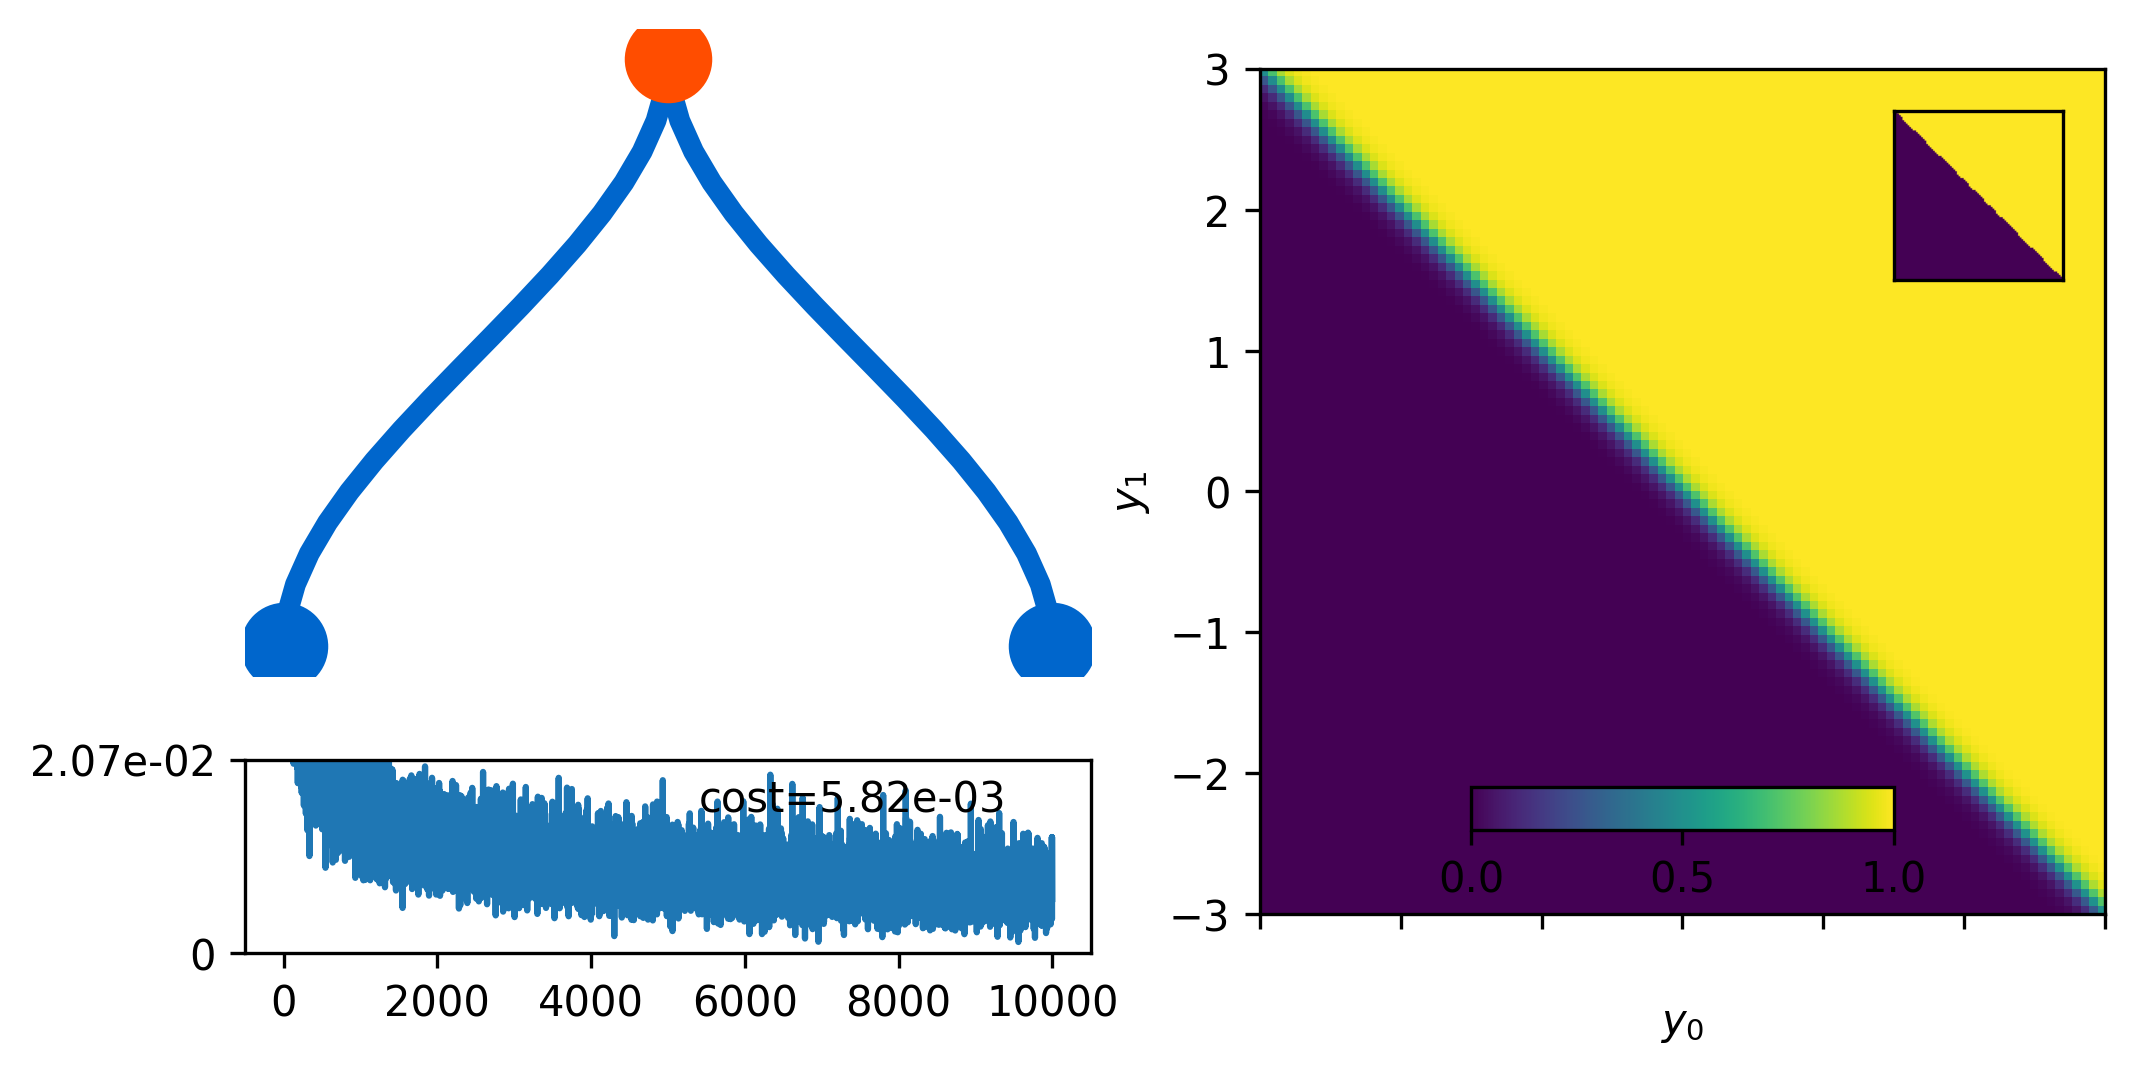

In [26]:
def my_target(y):
    return ( 1.0 * ( (y[:,0] + y[:,1]) > 0 ) )

visualize_network_training(
    weights=[ [ [0.2,-0.9] ] ], # weights of 2 input neurons for single output neuron
    biases=[ [0.0] ], # bias for single output neuron
    target_function=my_target, # the target function to approximate
    activations=[ sigmoid ], # activation for output
    y0range=[-3,3],
    y1range=[-3,3],
    steps=10000,
    eta=5.,
    batchsize=200,
    visualize_nsteps=1000,
    plot_target=True)



### Example 2: Training for a quarter-space AND function

/tmp/ipython-input-651157670.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)


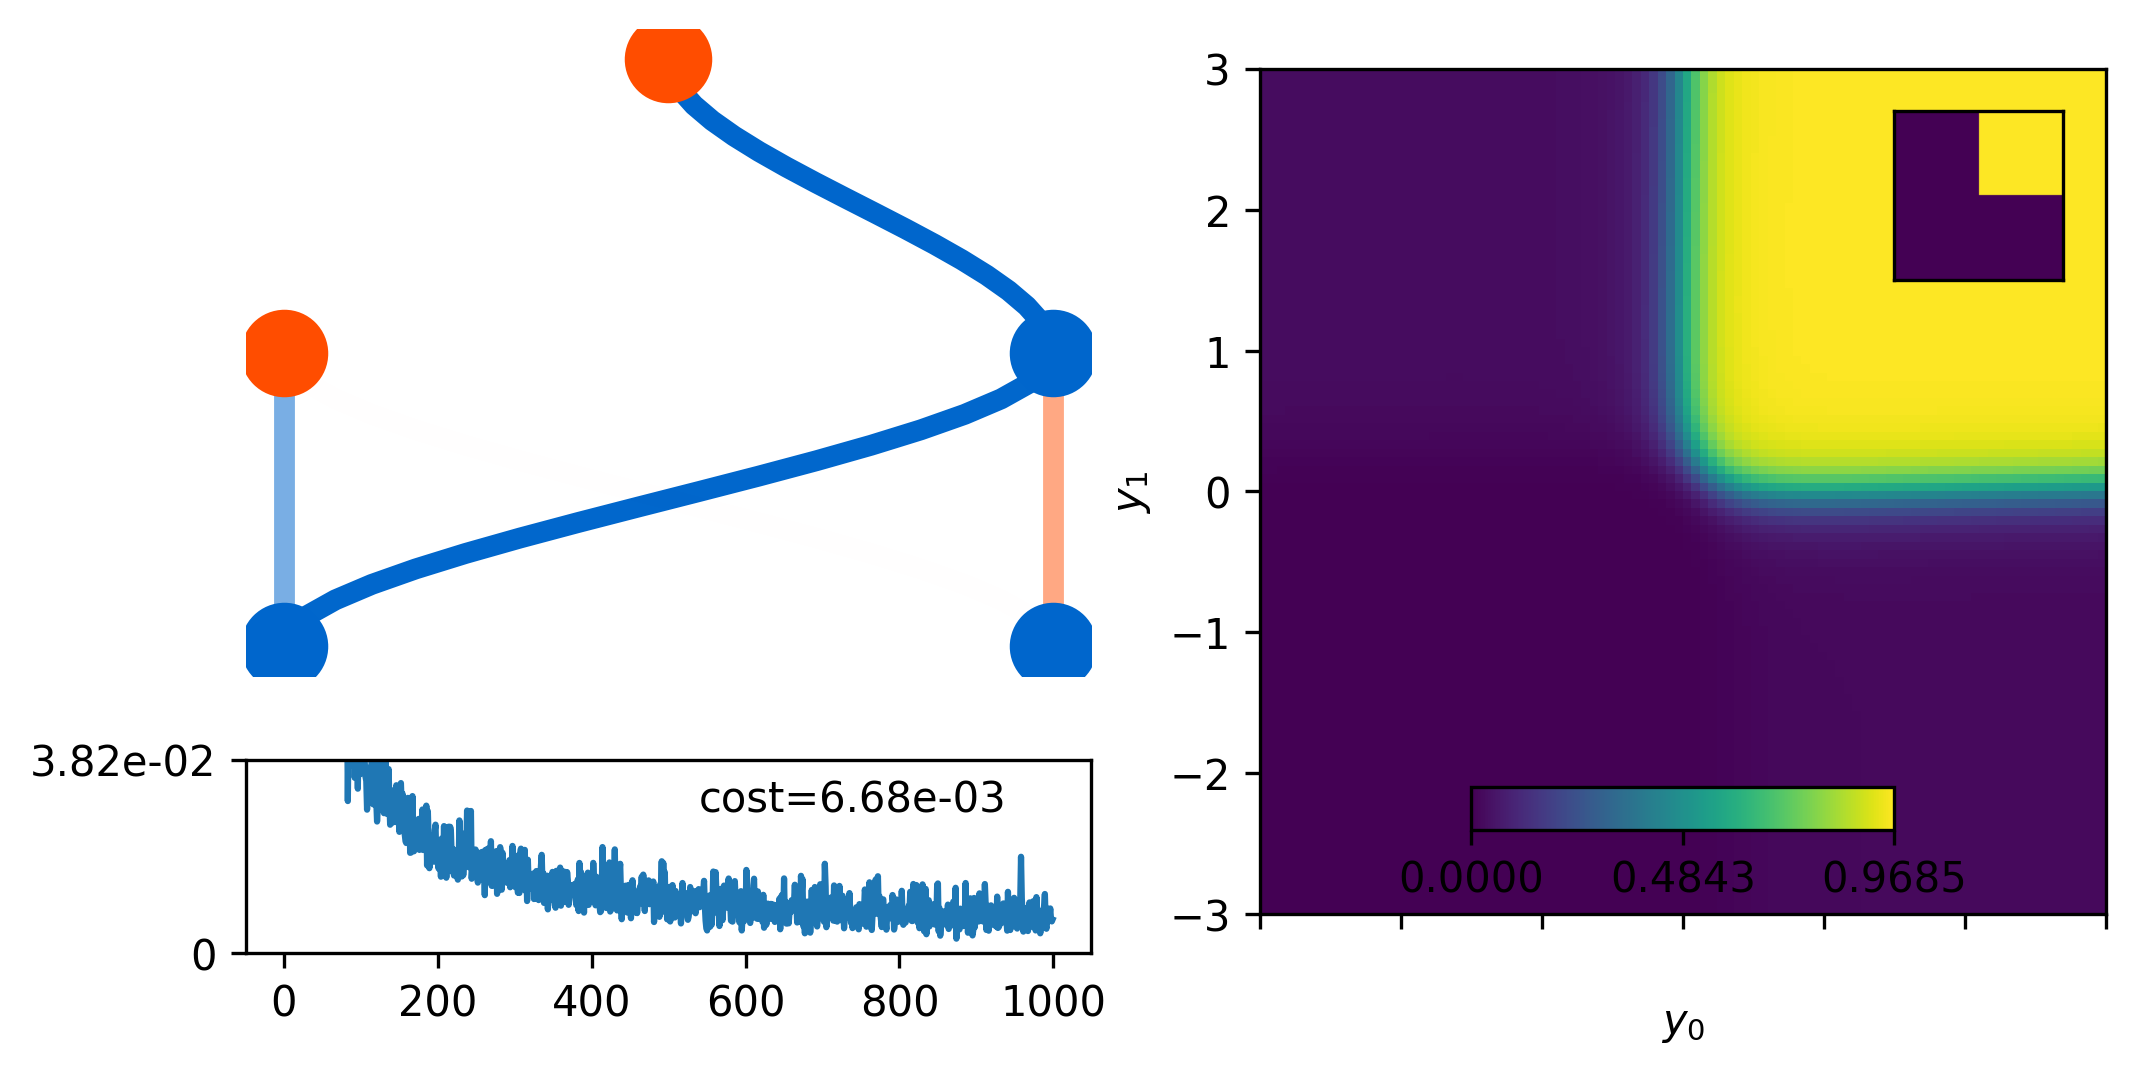

In [27]:
def my_target(y):
    return( 1.0* (y[:,0]> 0) * (y[:,1]>0) )

visualize_network_training(weights=[ [ [0.2,-0.9], [0.3,0.4]],
                                     [ [0.2,0.5] ] ],
                            biases=[ [0.1,-0.2], [0.0] ],
                            target_function=my_target,
                            activations=[ sigmoid, sigmoid],
                            y0range=[-3,3],
                            y1range=[-3,3],
                            yspread=3,
                            steps=1000,
                            eta=5.,
                            batchsize=200,
                            visualize_nsteps=100)

### Example 2b: Training for a quarter-space AND function, with multiple randomly initialized reLU layers

This also demonstrates how to start from randomly initialized layers, for convenience.

When it works, reLU is very efficient; however, 'wrong choices' for the initialization can simply give zero as output and no training!

Rerun this cell multiple times to see this.


/tmp/ipython-input-651157670.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)


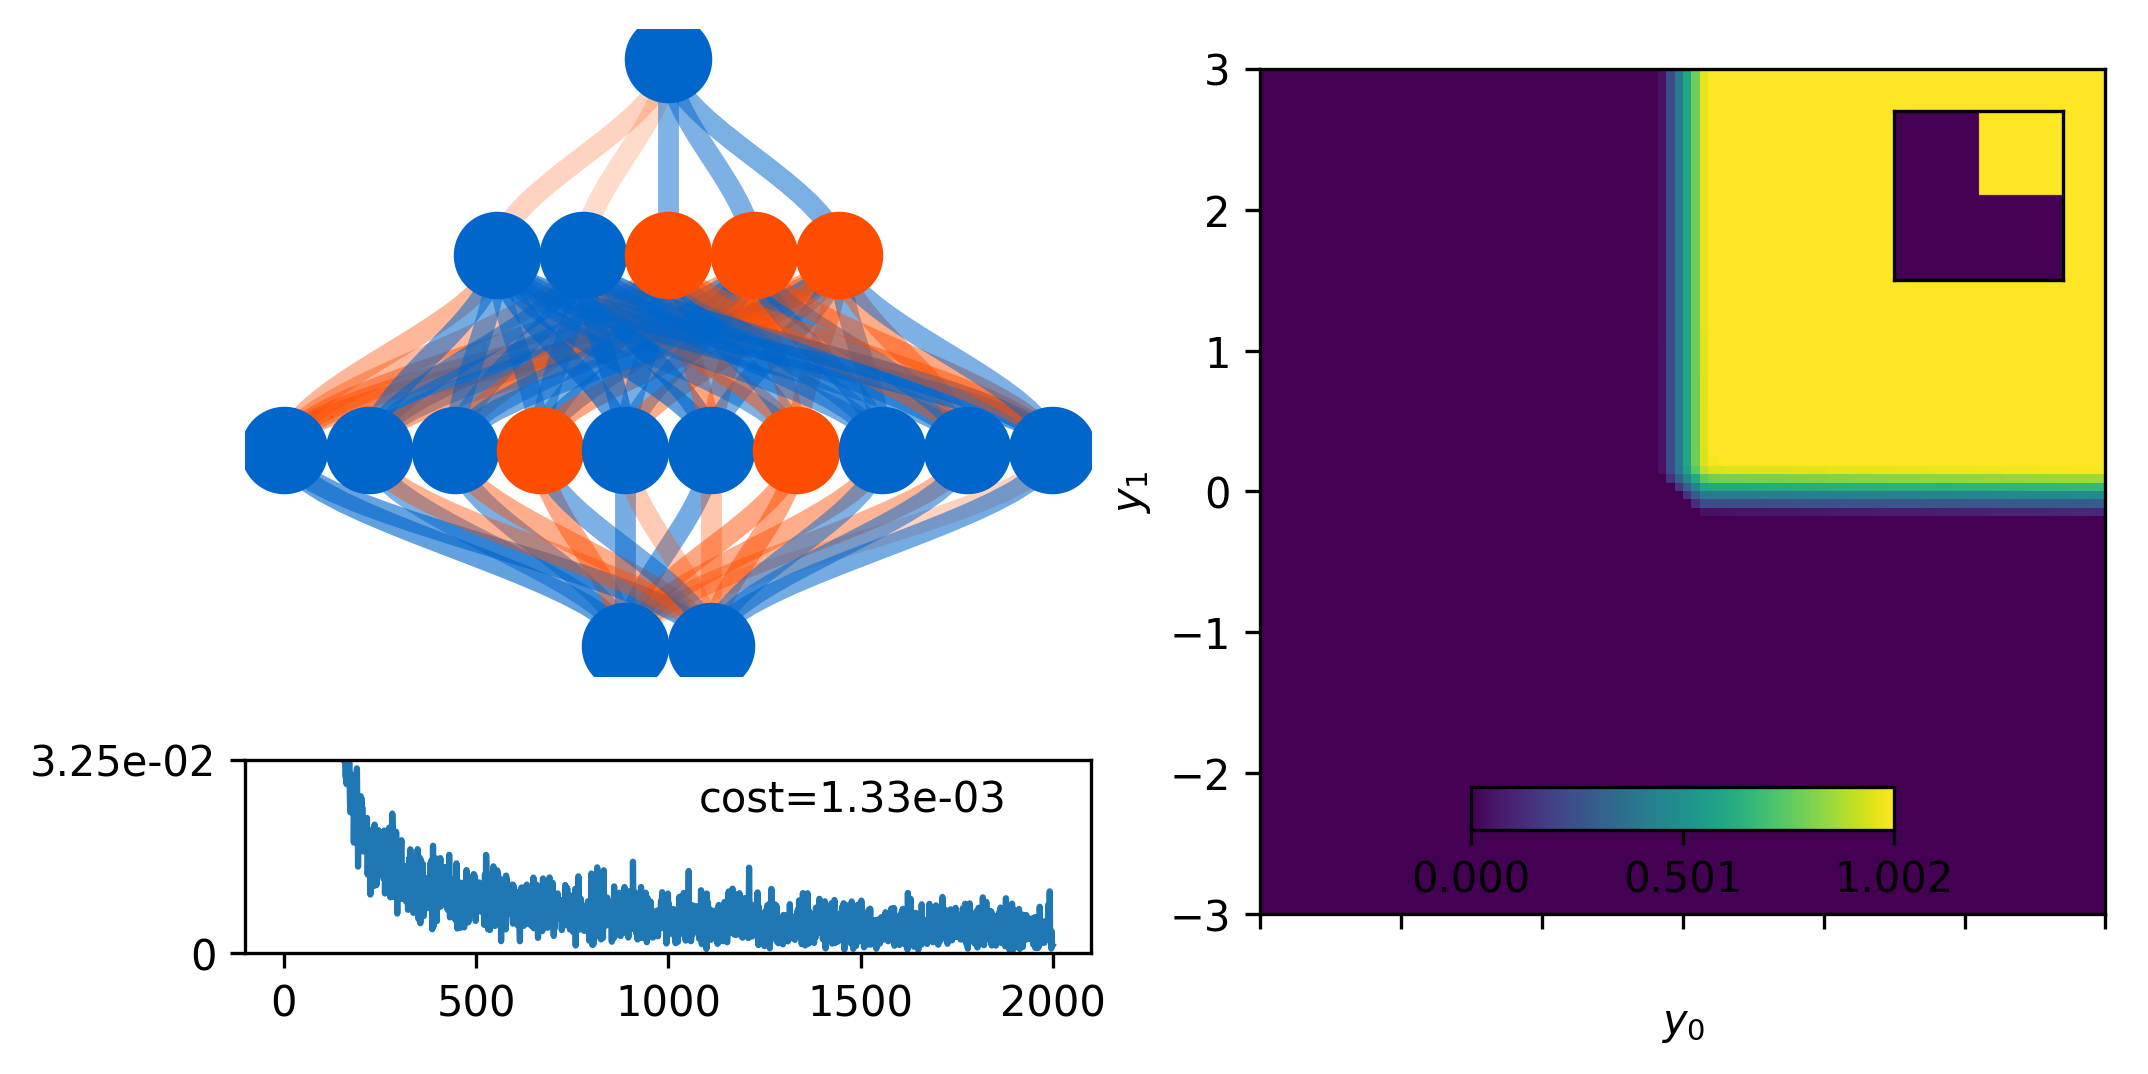

In [31]:
def my_target(y):
    return( 1.0 * (y[:,0]> 0) * (y[:,1]>0) )

visualize_network_training( weights=[],biases=[],
                            num_neurons=[2,10,5,1], # this generates randomly initialized layers of the given neuron numbers!
                            bias_scale=0.0, weight_scale=0.1, # the scale of the random numbers
                            target_function=my_target, # the target function to approximate
                            activations=[ relu, relu, relu ],
                            y0range=[-3,3],y1range=[-3,3],
                            yspread=3,
                            steps=2000, eta=.2, batchsize=200,
                            visualize_nsteps=200)


### Exercise 1: "Training an XOR"

Try to train on the 'XOR' function, defined by:

  +1 for y0*y1<0   and 0 otherwise !

  How do you define it ? (look at the code above...)
  How do you lay out your network? (how many layers, how many neurons, which activations)
  How does the learning success depend on these choices and the learning parameters (like eta) ?

/tmp/ipython-input-651157670.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)


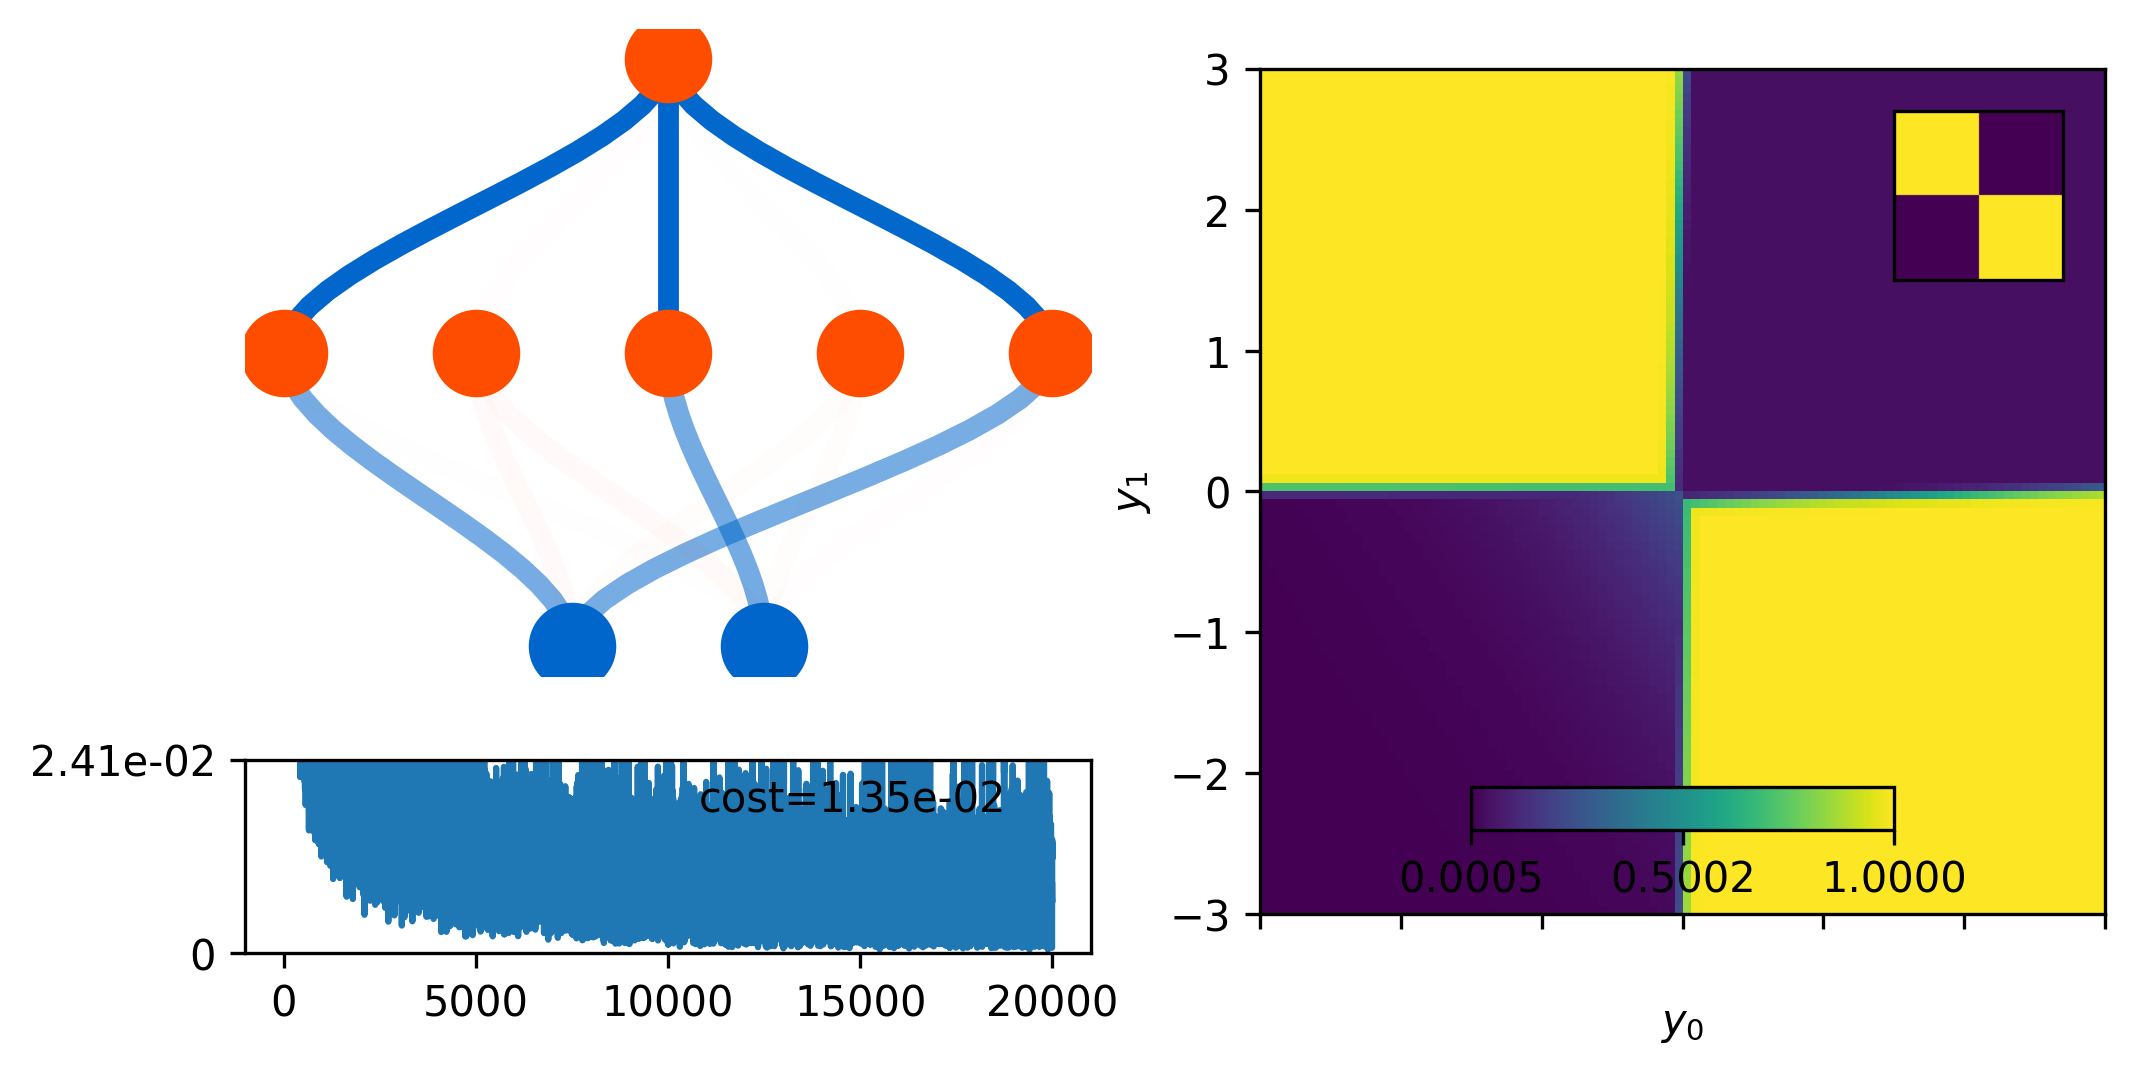

In [57]:
# Your Code:
def xor_target(y):
    return(y[:,0] * y[:,1] < 0)

visualize_network_training( weights=[],biases=[],
                            num_neurons=[2,5,1], # this generates randomly initialized layers of the given neuron numbers!
                            bias_scale=0.0, weight_scale=0.1, # the scale of the random numbers
                            target_function=xor_target, # the target function to approximate
                            activations=[ relu, sigmoid, relu ],
                            y0range=[-3,3],y1range=[-3,3],
                            yspread=3,
                            steps=20000, eta=1, batchsize=200,
                            visualize_nsteps=2000)


In [ ]:
# @title Hint

# If you cannot get it to work properly, these parameter values worked for me,
# for a single hidden layer of 5 neurons and sigmoids:

# steps=5000, eta=.5, batchsize=200, visualize_nsteps=200


/tmp/ipython-input-651157670.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)


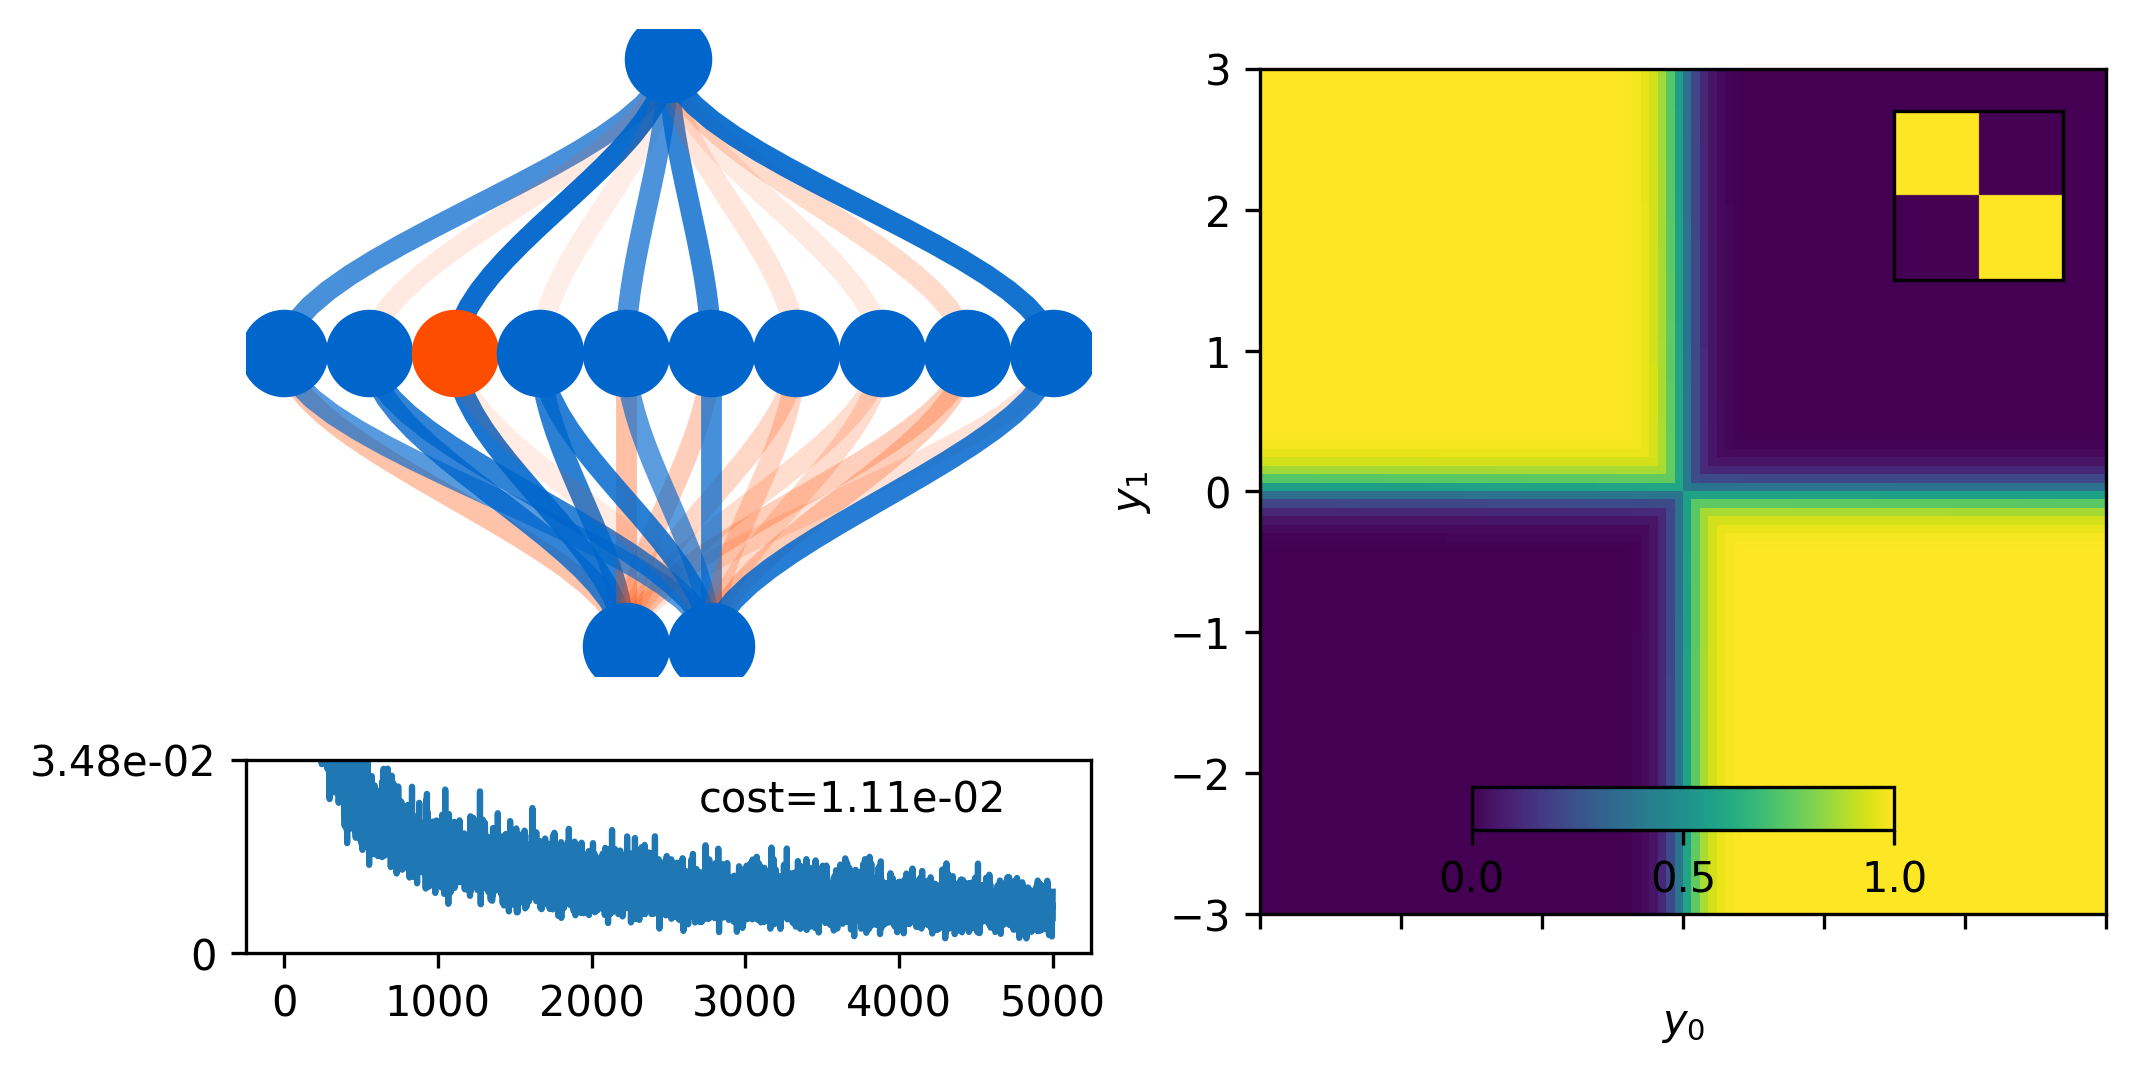

In [58]:
# @title Solution

def my_target(y):
    return( 1.0 * (y[:,0]*y[:,1]<0) )

visualize_network_training( weights=[],biases=[],
                            num_neurons=[2, 10, 1],
                            bias_scale=0.0, weight_scale=0.1,
                            target_function=my_target,
                            activations=[ relu, sigmoid ],
                            y0range=[-3,3],y1range=[-3,3],
                            yspread=3,
                            steps=5000, eta=.5, batchsize=200,
                            visualize_nsteps=200)


### Exercise 2: "Training on an arbitrary function"

Invent your own interesting function! Explore in the same way as the XOR!

For example, a function that defines a circle, i.e. +1 inside the circle (easy)!

Or a circle with a hole inside (harder)!

Or the following (really hard):



```
def my_target(y):
    a=0.8; r=0.5; R=2.0
    return( 1.0*( y[:,0]**2+y[:,1]**2<R**2 ) - 1.0*( (y[:,0]-a)**2+(y[:,1]-a)**2<r**2) - 1.0*( (y[:,0]+a)**2+(y[:,1]-a)**2<r**2 ) )
```


In [ ]:
# Your Code:




In [ ]:
# @title Solution 1

def my_target(y): # Circle with hole
    a = 2.
    r2 = (y[:,0]**2 + y[:,1]**2)
    return( 1. * (r2 < a**2) )

visualize_network_training( weights=[],biases=[],
                            num_neurons=[2, 20, 20, 1],
                            bias_scale=0.0, weight_scale=0.1,
                            target_function=my_target,
                            activations=[ relu, relu, sigmoid ],
                            y0range=[-3,3],y1range=[-3,3],
                            yspread=3,
                            steps=10000, eta=.2, batchsize=300,
                            visualize_nsteps=1000)



In [ ]:
# @title Solution 2

def my_target(y): # Circle with hole
    a = 2.
    b = 1.
    r2 = (y[:,0]**2 + y[:,1]**2)
    return( 1. * (r2 < a**2) - 1. * (r2 < b**2))

visualize_network_training( weights=[],biases=[],
                            num_neurons=[2, 20, 20, 20, 1],
                            bias_scale=0.0, weight_scale=0.1,
                            target_function=my_target,
                            activations=[ relu, relu, sigmoid, sigmoid ],
                            y0range=[-3,3],y1range=[-3,3],
                            yspread=3,
                            steps=20000, eta=.5, batchsize=300,
                            visualize_nsteps=5000)


/tmp/ipython-input-651157670.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)


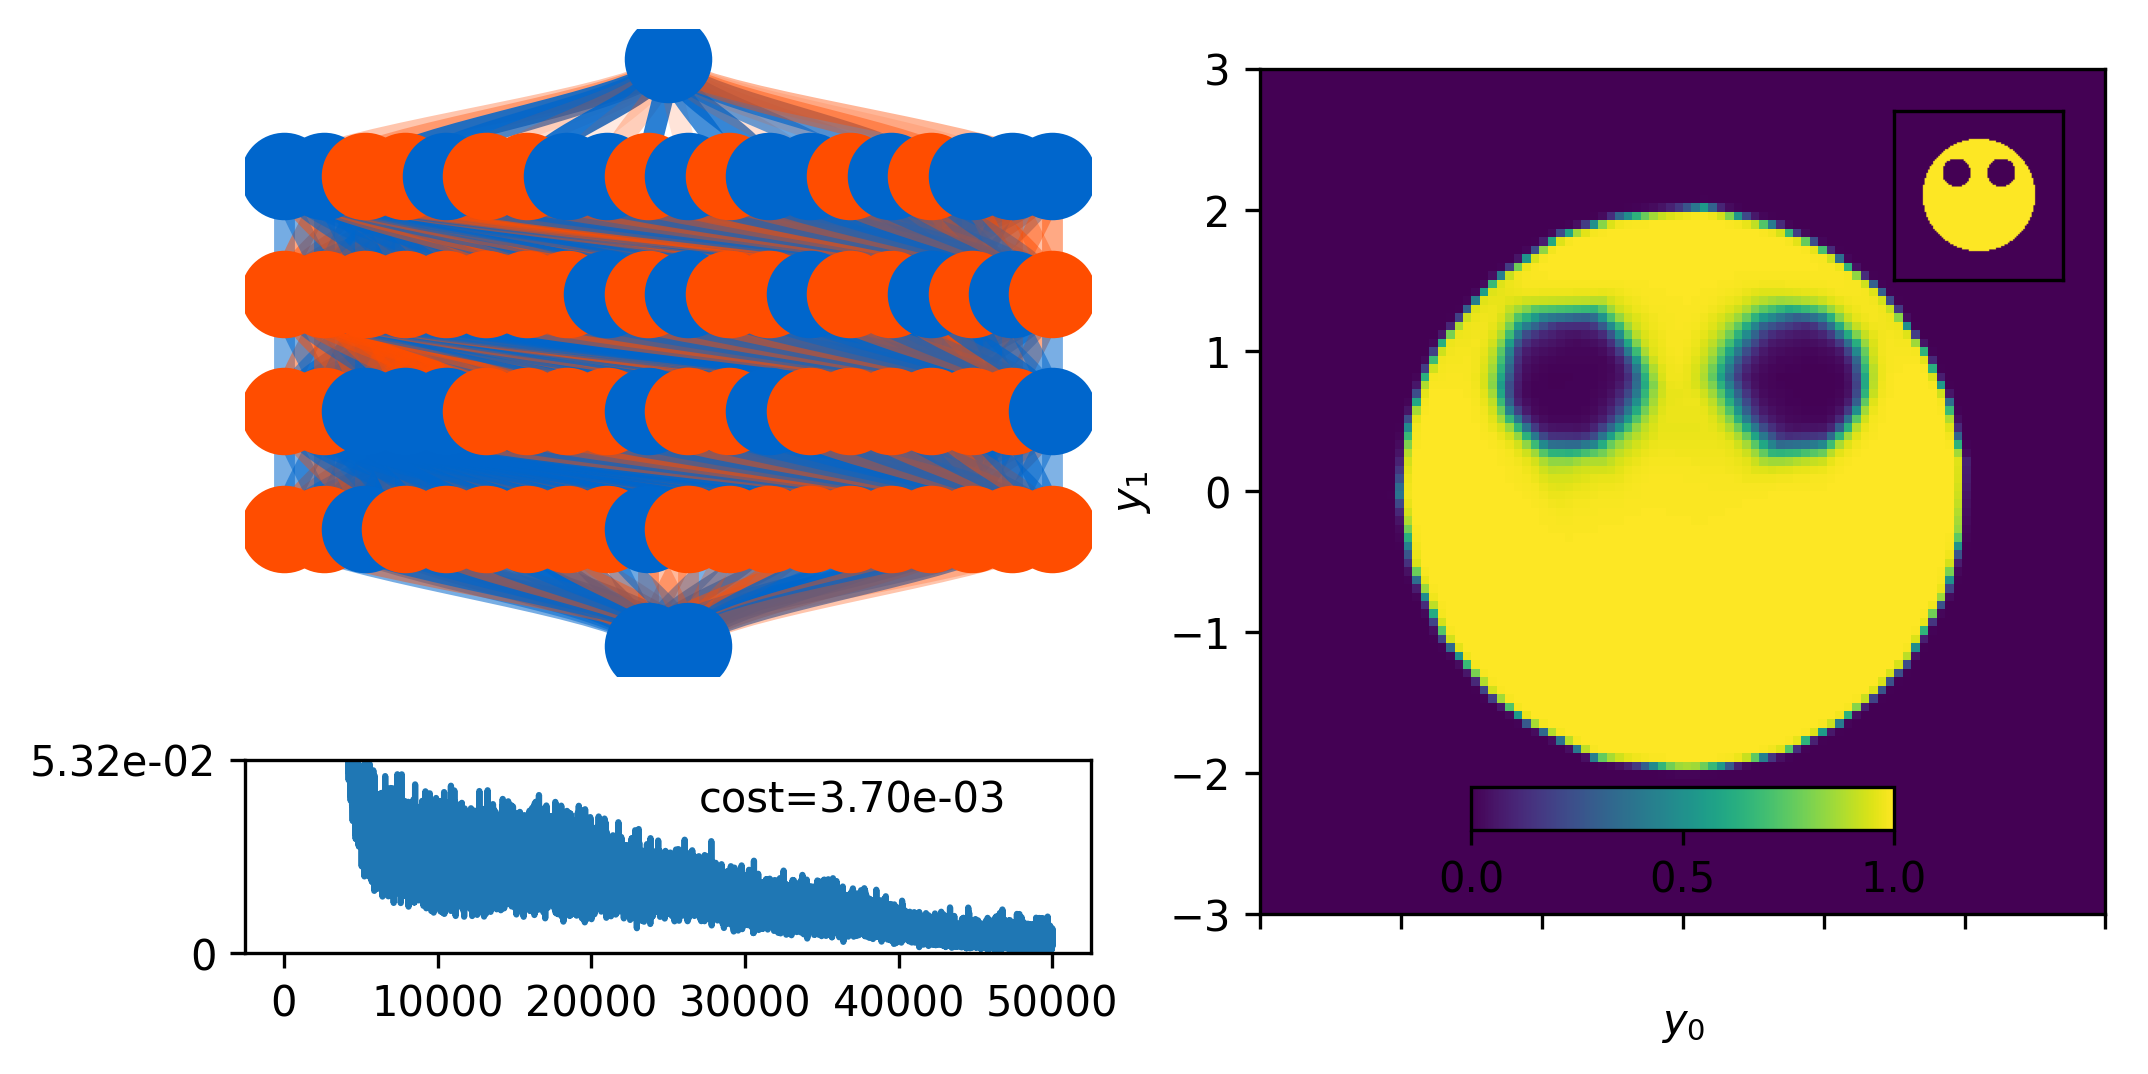

In [59]:
# @title Solution 3
def my_target(y):
    a=0.8; r=0.5; R=2.0
    return( 1.0*( y[:,0]**2+y[:,1]**2<R**2 ) - 1.0*( (y[:,0]-a)**2+(y[:,1]-a)**2<r**2) - 1.0*( (y[:,0]+a)**2+(y[:,1]-a)**2<r**2 ) )


visualize_network_training( weights=[],biases=[],
                            num_neurons=[2, 20, 20, 20, 20, 1],
                            bias_scale=0.0, weight_scale=0.1,
                            target_function=my_target,
                            activations=[ relu, relu, relu, sigmoid, sigmoid ],
                            y0range=[-3,3],y1range=[-3,3],
                            yspread=3,
                            steps=50000, eta=.2, batchsize=500,
                            visualize_nsteps=10000)